# Implement a Siamese network

This lab will go through creating and training a multi-input model. You will build a basic Siamese Network to find the similarity or dissimilarity between items of clothing.

## Imports

In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

## Prepare the Dataset

First define a few utilities for preparing and visualizing your dataset.

In [24]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1 # 正负样本个数

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1] #  构建正样本
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] # 构建负样本
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)] # 每个类的index 
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

You can now download and prepare our train and test sets. You will also create pairs of images that will go into the multi-input model.

What Is Fashion-MNIST?
Fashion-MNIST as the name suggests is a dataset of fashion items. Specifically, the dataset has the following ten classes of fashion items:

| Index 	| Label       	|
|-------	|-------------	|
| 0     	| T-shirt/top 	|
| 1     	| Trouser     	|
| 2     	| Pullover    	|
| 3     	| Dress       	|
| 4     	| Coat        	|
| 5     	| Sandal      	|
| 6     	| Shirt       	|
| 7     	| Sneaker     	|
| 8     	| Bag         	|
| 9     	| Ankle boot  	|

![IMAGE](https://deeplizard.com/images/fashion-mnist.jpg)


In [27]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# fashion mnist 共十个类，共 60000 训练集，每个类6000条

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [56]:
tr_pairs.shape

(119980, 2, 28, 28)

You can see a sample pair of images below.

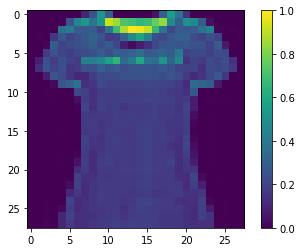

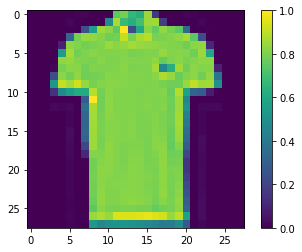

1.0


In [43]:
# array index
this_pair = 

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(tr_y[this_pair])

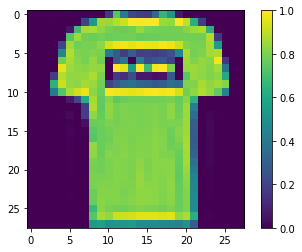

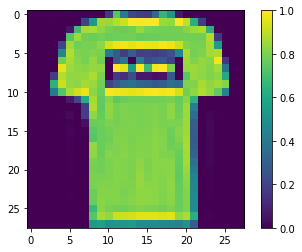

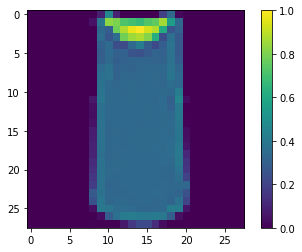

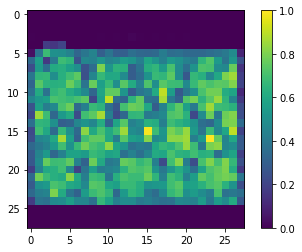

In [57]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])  # tr_pairs[0,1]== tr_pairs[:, 1][0]
show_image(tr_pairs[:,1][1])

## Build the Model

Next, you'll define some utilities for building our model.

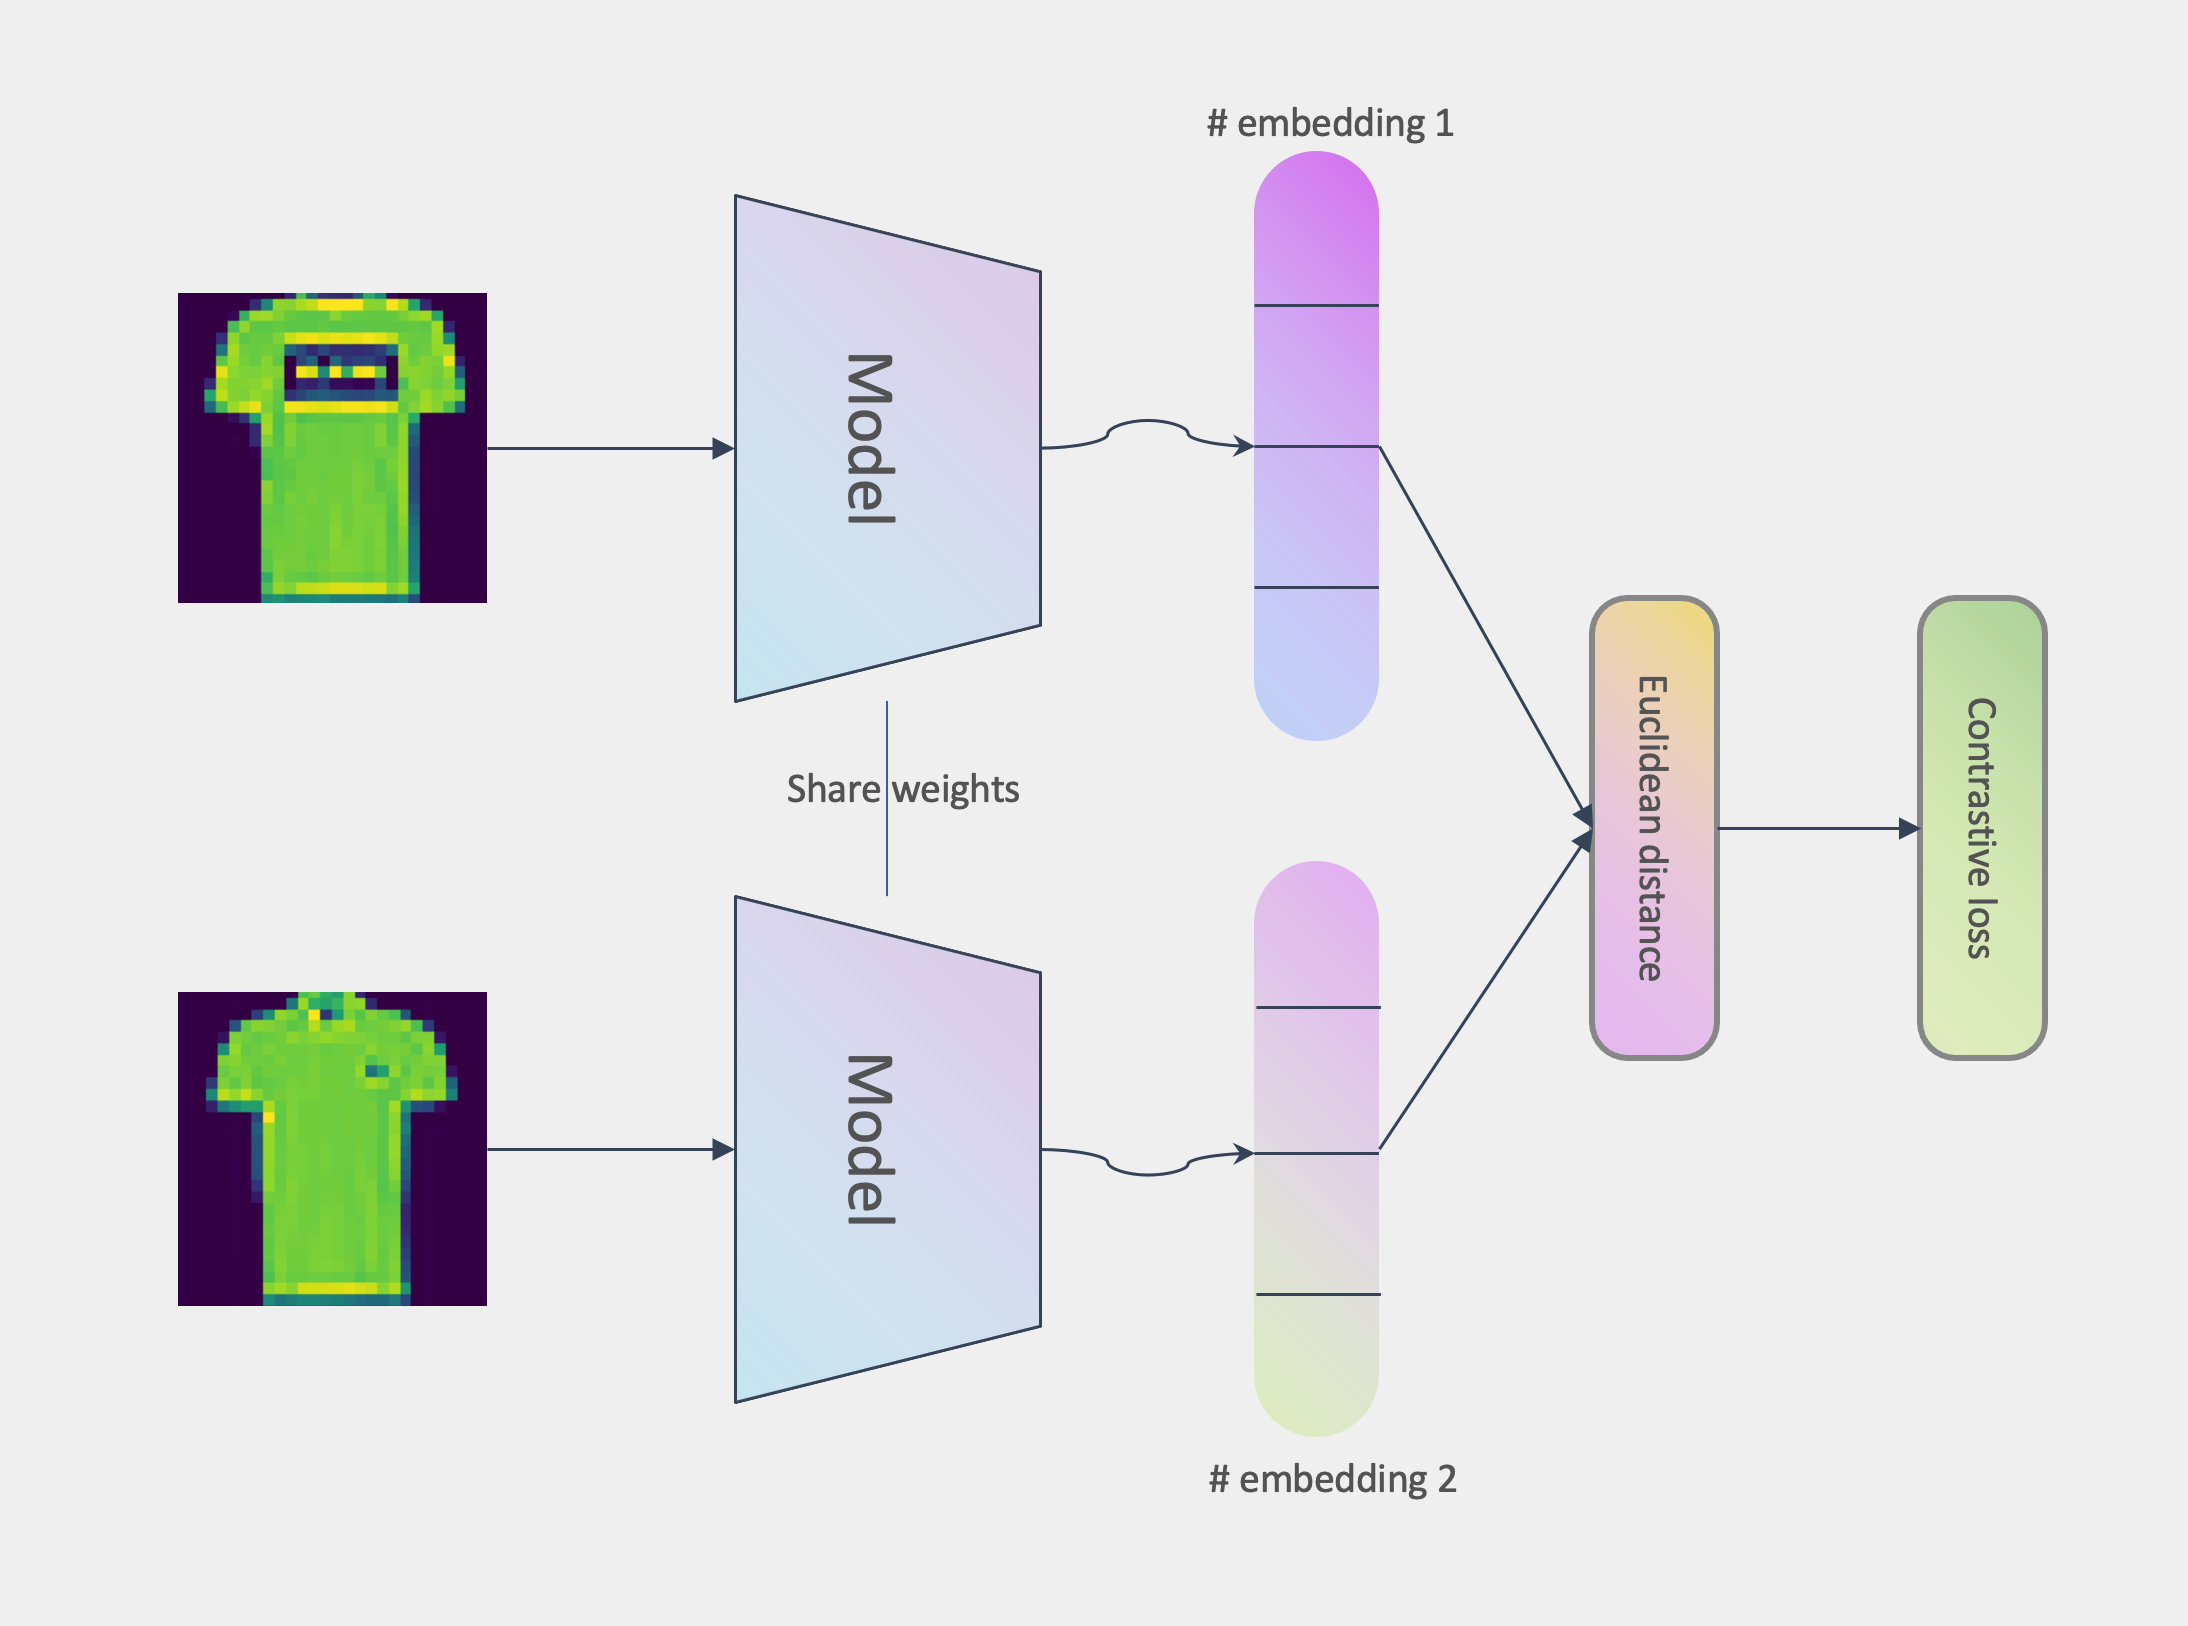

### **base network**
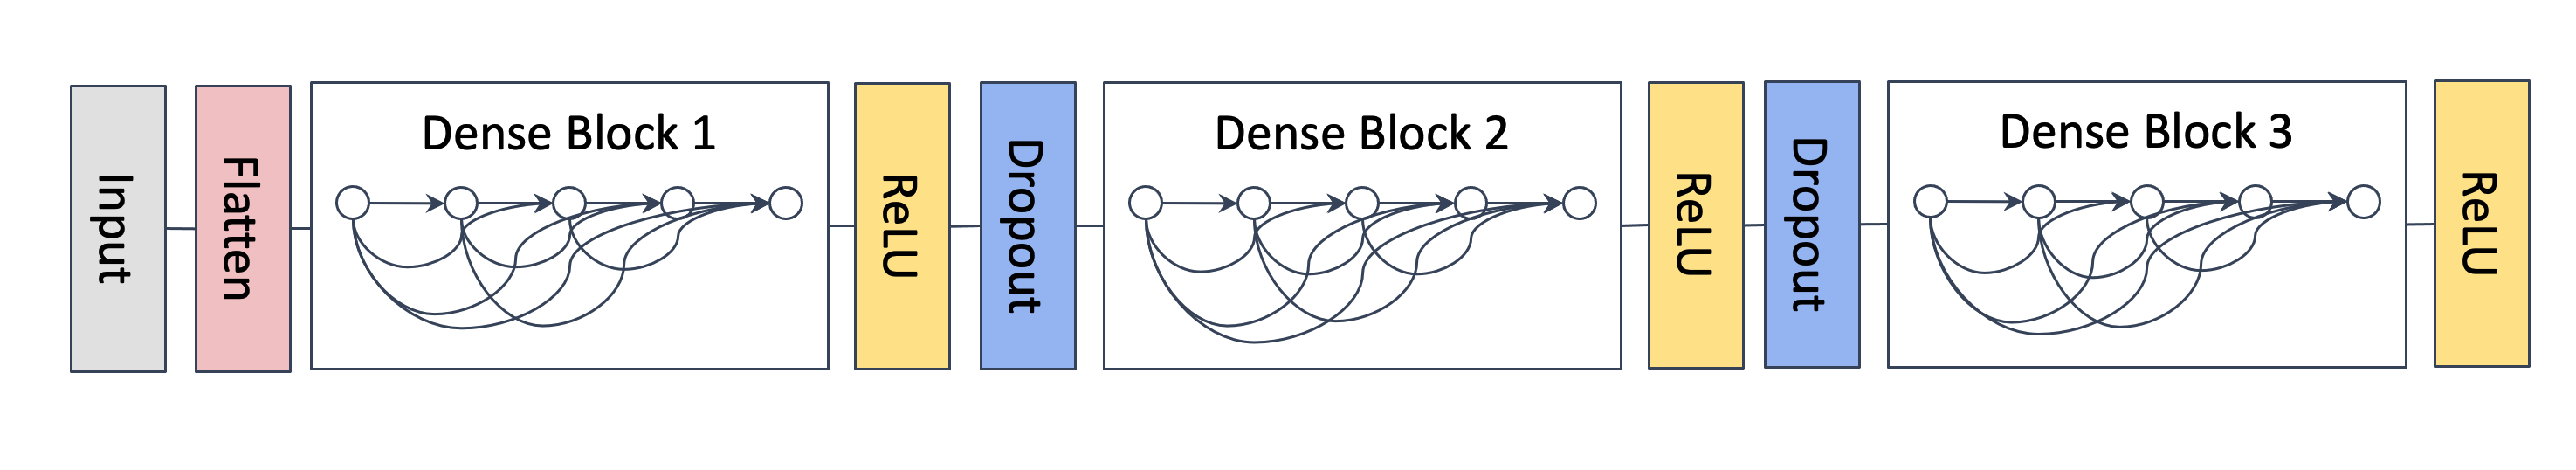

#### Implemented with functional API

In [139]:
# Implemented with functional API
def initialize_base_network_func():
    input_ = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input_)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input_, outputs=x)


#### Implemented with sequential API

In [140]:
# Implemented with sequential API
def initialize_base_network_seq():
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(28, 28, ), name="base_input"))
    model.add(Flatten(name="flatten_input"))
    model.add(Dense(128, activation='relu', name="first_base_dense"))
    model.add(Dropout(0.1, name="first_dropout"))
    model.add(Dense(128, activation='relu', name="second_base_dense"))
    model.add(Dropout(0.1, name="second_dropout"))
    model.add(Dense(128, activation='relu', name="third_base_dense"))
    return model

#### Implemented with subclass API

In [141]:
class BaseNetwork(tf.keras.models.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.flatten_input = Flatten(name="flatten_input")
    self.first_base_dense = Dense(128, activation='relu', name="first_base_dense")
    self.first_dropout = Dropout(0.1, name="first_dropout")
    self.second_base_dense = Dense(128, activation='relu', name="second_base_dense")
    self.second_dropout = Dropout(0.1, name="second_dropout")
    self.third_base_dense = Dense(128, activation='relu', name="third_base_dense")
  
  def call(self, input_):
    output = self.flatten_input(input_)
    output = self.first_base_dense(output)
    output = self.first_dropout(output)
    output = self.second_base_dense(output)
    output = self.second_dropout(output)
    output = self.third_base_dense(output)
    return output

Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.

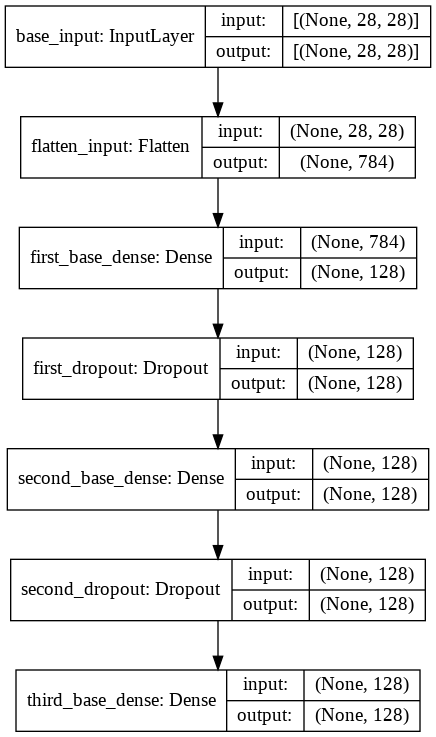

In [77]:
base_network = initialize_base_network_func()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

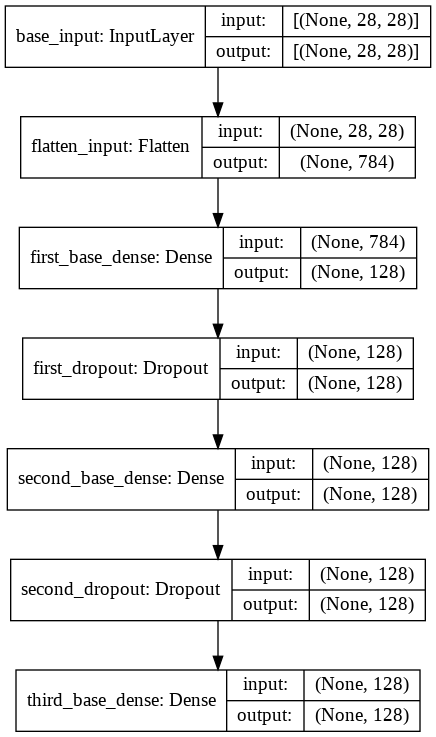

In [83]:
base_network = initialize_base_network_seq()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model2.png')

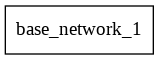

In [92]:
base_network = BaseNetwork()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model3.png')

Let's now build the Siamese network. The plot will show two inputs going to the base network.

In [80]:
# create the left input and point to the base network
input_1 = Input(shape=(28,28), name="left_input")
embedding1 = base_network(input_1)

# create the right input and point to the base network
input_2 = Input(shape=(28,28), name="right_input")
embedding2 = base_network(input_2)

### Euclidean Distance Layer

ref:


$euclidean_distance(p,q) = \sqrt{(p_1- q_1)^2 + (p_2 - q_2)^2+\cdots+(p_i - q_i)^2+\cdots+(p_n - q_n)^2}$




In [116]:

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

#### Customized Layer

In [129]:
test_embd1, test_embd2 = np.array([[1.0, 2.0, 3.0]]), np.array([[1.0, 2.0, 3.0]])

# create customized layer
class CustomizedEuclideanDistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        '''构建所需要的参数'''
        super().build(input_shape)
        # 这边没有
    
    def call(self, inputs):
        '''完成正向计算'''
        return euclidean_distance(inputs)
euclidean_dis_layer_cus = CustomizedEuclideanDistanceLayer(name='output_layer')


In [130]:
# test customized layer
euclidean_dis_layer_cus([embd1, embd2])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00031623]], dtype=float32)>

#### Lambda layer
for layer with no parameters, it can be created by Lmabda simply


In [131]:
euclidean_dis_layer_lambda = Lambda(euclidean_distance, name="outpur_layer", output_shape=eucl_dist_output_shape)

In [132]:
# test lambda layer
euclidean_dis_layer_lambda([embd1, embd2])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00031623]], dtype=float32)>

### Build Siamese Model
#### Implemented with Functional API

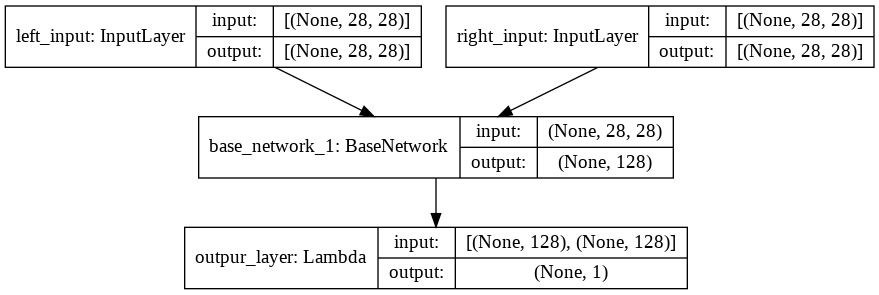

In [133]:
## Implemented with Functional API
# measure the similarity of the two vector outputs
output = euclidean_dis_layer_lambda([embedding1, embedding2])

# specify the inputs and output of the model
model = Model([input_1, input_2], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

#### Implemented with subclass API

In [135]:
#### Implemented with subclass API

class SiameseModel(tf.keras.models.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.base_model = BaseNetwork()
    self.euclidean_dis_layer = Lambda(euclidean_distance, name="outpur_layer", output_shape=eucl_dist_output_shape)
  
  def call(self, inputs):
    input_1, input_2 = inputs

    embedding1 = self.base_model(input_1)
    embedding2 = self.base_model(input_2)

    output = self.euclidean_dis_layer([embedding1, embedding2])
    return output

model = SiameseModel()    

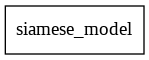

In [138]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

## Train the Model

You can now define the custom loss for our network and start training. Don't worry about why it's written as a nested function just yet. You will revisit this in Week 2.

In [1]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square) # 正样本pair越小，让负样本pair 距离越大，且必须要大于margin，否则的话 所有 y_predict 都等于0，loss也是0
    return contrastive_loss

In [137]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 9s 9ms/step - loss: 0.1598 - val_loss: 0.0948
Epoch 2/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0814 - val_loss: 0.0745
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0730 - val_loss: 0.0770
Epoch 4/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0671 - val_loss: 0.0711
Epoch 5/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0651 - val_loss: 0.0697
Epoch 6/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0622 - val_loss: 0.0688
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0602 - val_loss: 0.0665
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0590 - val_loss: 0.0666
Epoch 9/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0570 - val_loss: 0.0649
Epoch 10/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0568 - val_loss: 0.0690

## Model Evaluation

As usual, you can evaluate our model by computing the accuracy and observing the metrics during training.

In [96]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [97]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 1ms/step - loss: 0.0642
Loss = 0.0642402321100235, Train Accuracy = 0.9383147191198533 Test Accuracy = 0.9127127127127127


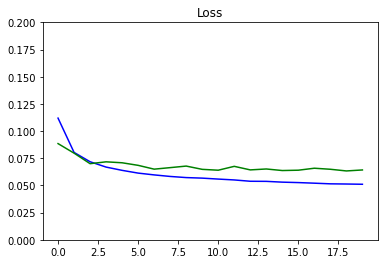

In [98]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [99]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



You can see sample results for 10 pairs of items below.

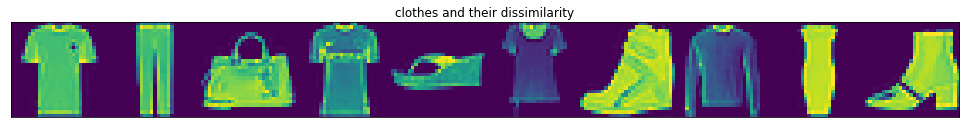

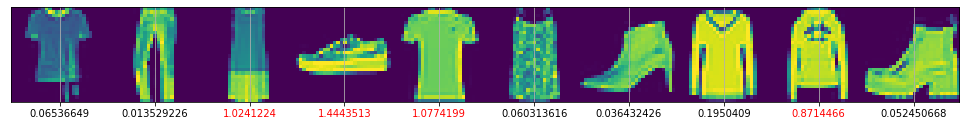

In [100]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)